### Case Study

Continuation on from the previous notebook, we are now going to take a very basic moving average cross-over strategy and see if we can improve upon the returns by selecting only favourable HMM states which are generated as out-of-sample data for maximum caution.

We will also see how a quick backtest can be constructed and Equity curves along with Sharpe Ratios etc created.

### Imports

In [220]:
import pandas as pd
import numpy as np

from pyhhmm.gaussian import GaussianHMM
import yfinance as yf

import matplotlib.pyplot as plt

### Structure Data

In [ ]:
# Data Extraction
start_date = "2017-01-1"
end_date = "2024-12-31"
symbol = "BTC-USD"
data = yf.download(symbol, start=start_date, end=end_date)
data = data[["Open", "High", "Low", "Adj Close"]]

[*********************100%%**********************]  1 of 1 completed


In [222]:
# Add Returns and Range
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
print("Length: ", len(df))
df.head()

Length:  2000


,Open,High,Low,Adj Close,Returns,Range
Date,,,,,,
2017-01-04,225.619995,226.750000,225.610001,199.130508,0.005949,0.005053
2017-01-05,226.270004,226.580002,225.479996,198.972336,-0.000794,0.004879
2017-01-06,226.529999,227.750000,225.899994,199.684219,0.003578,0.008189
2017-01-09,226.910004,227.070007,226.419998,199.025101,-0.003301,0.002871
2017-01-10,226.479996,227.449997,226.009995,199.025101,0.000000,0.006371


In [223]:
# Add Moving Average
df["MA_12"] = df["Adj Close"].rolling(window=12).mean()
df["MA_21"] = df["Adj Close"].rolling(window=21).mean()

In [224]:
# Structure Data
X_train = df[["Returns", "Range"]].iloc[:500]
X_test = df[["Returns", "Range"]].iloc[500:]
save_df = df.iloc[500:]

print("Train Length: ", len(X_train))
print("Test Length: ", len(X_test))
print("X_train From: ", X_train.head(1).index.item())
print("X_train To: ", X_train.tail(1).index.item())
print("X_test From: ", X_test.head(1).index.item())
print("X_test To: ", X_test.tail(1).index.item())

Train Length:  500
Test Length:  1500
X_train From:  2017-01-04 00:00:00
X_train To:  2018-12-28 00:00:00
X_test From:  2018-12-31 00:00:00
X_test To:  2024-12-13 00:00:00


### Train HMM

In [225]:
# Train HMM
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])
model.predict([X_train.values])[0][:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [226]:
# Make Prediction on Test Data
df_main = save_df.copy()
df_main.drop(columns=["High", "Low"], inplace=True)

hmm_results = model.predict([X_test.values])[0]
df_main["HMM"] = hmm_results
df_main.head()

,Open,Adj Close,Returns,Range,MA_12,MA_21,HMM
Date,,,,,,,
2018-12-31,249.559998,228.166260,0.008759,0.010991,227.688466,234.974480,0
2019-01-02,245.979996,228.403625,0.001040,0.021387,226.650035,234.008947,2
2019-01-03,248.229996,222.953293,-0.023863,0.020109,225.528028,232.711695,3
2019-01-04,247.589996,230.421295,0.033496,0.024032,225.414862,231.612297,1
2019-01-07,252.690002,232.238068,0.007885,0.016926,225.474277,230.990572,0


### Run Backtest

In [227]:
# Add MA Signals
df_main.loc[df_main["MA_12"] > df_main["MA_21"], "MA_Signal"] = 1
df_main.loc[df_main["MA_12"] <= df_main["MA_21"], "MA_Signal"] = 0

In [228]:
# Add HMM Signals
favourable_states = [0, 3] # States where you trade. (try each separetly and stay with the once that gives the best results)
hmm_values = df_main["HMM"].values
hmm_values = [1 if x in favourable_states else 0 for x in hmm_values]
df_main["HMM_Signal"] = hmm_values

In [229]:
# Add Combined Signal
df_main["Main_Signal"] = 0
df_main.loc[(df_main["MA_Signal"] == 1) & (df_main["HMM_Signal"] == 1), "Main_Signal"] = 1
df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [230]:
# Benchmark Returns
df_main["lrets_bench"] = np.log(df_main["Adj Close"] / df_main["Adj Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exp"] = np.exp(df_main["bench_prod"]) - 1

In [231]:
# Strategy Returns
df_main["lrets_strat"] = np.log(df_main["Open"].shift(-1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exp"] = np.exp(df_main["lrets_prod"]) - 1

In [232]:
# Review Results Table
df_main.dropna(inplace=True)
df_main.tail()

,Open,Adj Close,Returns,Range,MA_12,MA_21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exp,lrets_strat,lrets_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,
2024-12-06,607.440002,607.809998,0.001896,0.003377,600.742498,597.767142,0,1.0,1,1.0,0.001894,0.979788,1.663891,0.000411,0.049177,0.050406
2024-12-09,607.690002,604.679993,-0.005150,0.006257,601.924164,598.199047,0,1.0,1,1.0,-0.005163,0.974625,1.650173,-0.003825,0.045352,0.046396
2024-12-10,605.369995,602.799988,-0.003109,0.006095,602.684998,598.418570,0,1.0,1,1.0,-0.003114,0.971511,1.641933,0.000677,0.046029,0.047104
2024-12-11,605.780029,607.460022,0.007731,0.004839,603.680832,598.832857,0,1.0,1,1.0,0.007701,0.979212,1.662357,0.001320,0.047348,0.048487
2024-12-12,606.580017,604.330017,-0.005153,0.004683,604.247498,599.186666,0,1.0,1,1.0,-0.005166,0.974046,1.648639,-0.000297,0.047052,0.048176


### Calculate Metrics

In [233]:
# Sharpe Ratio Function
def sharpe_ratio(returns_series):
    N = 255
    NSQRT = np.sqrt(N)
    rf = 0.01
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio

In [234]:
# Metrics
bench_rets = round(df_main["bench_prod_exp"].values[-1] * 100, 1)
strat_rets = round(df_main["strat_prod_exp"].values[-1] * 100, 1)

bench_sharpe = sharpe_ratio(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio(df_main["lrets_strat"].values)

In [235]:
# Print Metrics
print(f"Returns Benchmark: {bench_rets}%")
print(f"Returns Strategy: {strat_rets}%")
print("---- ---- ---- ---- ---- ----")
print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")

Returns Benchmark: 164.9%
Returns Strategy: 4.8%
---- ---- ---- ---- ---- ----
Sharpe Benchmark: 0.78
Sharpe Strategy: -0.02


### Plot Results

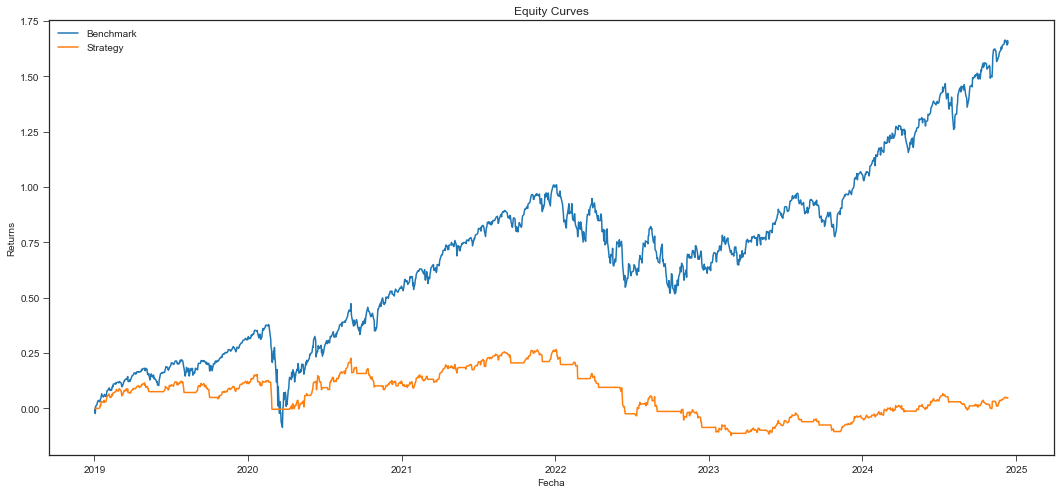

In [236]:
df_main.index = pd.to_datetime(df_main.index)

# Plot Equity Curves
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df_main.index, df_main["bench_prod_exp"], label="Benchmark")
ax.plot(df_main.index, df_main["strat_prod_exp"], label="Strategy")
ax.set_title("Equity Curves")
ax.set_xlabel("Fecha")
ax.set_ylabel("Returns")
ax.legend()
plt.show()

### Save Data

In [237]:
# Save Data
df_main.to_csv(f"data/HMM-{symbol}.csv")

### Conclusion

It is clear that the moving average cross-over strategy performs vastly better in both returns and Sharpe Ratio, when trading only in favourable hidden states determined by the Hidden Markov Model unsupervised learning method.

CAUTION: Backtesting is fraught with areas of inconsitency. The price assumptions made in our strategy for backtesting are highly unlikely going to be like prices based on a real trading environment. "Backtesting is not a research tool. Feature Importance is". - Marcos Lopez De Prado (Author of Advances in Financial Machine Learning).